# Categorical NN Classifier

In [1]:
%matplotlib inline

import os
import subprocess
import timeit
import numpy as np
import scipy as sp
import sympy as sy
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# functions for sparse matrices
from functools import reduce
from scipy.sparse import csc_matrix, dok_matrix, kron
#from sympy import radsimp, sqrt, init_printing

# functions to play animations
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

## Define Functions

In [20]:
# Activation (sigmoid) function
def identity(X):
    return X

def sigmoid(X):
    return 1 / (1 + np.exp(-np.array(X)))

def Dsigmoid(X):
    return np.array(X) * (1 - np.array(X))

def relu(X):
    return np.array([val if val>0 else 0.001 for val in X])
    
def Drelu(X):
    return np.array([1 if val>0 else 0 for val in X])

def softmax(X):
    exps = np.exp(X - np.max(X))
    return exps / np.sum(exps)

def Dsoftmax(X):
    derivatives = []
    Vsoft = softmax(X)
    
    for j in range(len(X)):
        derivatives.append([-Vsoft[j]*(1 - Vsoft[i]) if i==j else -Vsoft[i]*Vsoft[j] for i in range(len(X))])
        
    return np.asarray(derivatives)

def error_formula(y, output):
    return - y*np.log(output) - (1 - y) * np.log(1-output)

def error_term_formula(x, y, output):
    return (y - output)*Dsigmoid(x)

## Load Data

The dataset originally came from here: http://www.ats.ucla.edu/

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1


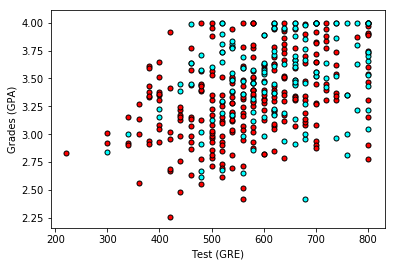

In [3]:
# Reading the csv file into a pandas DataFrame
data = pd.read_csv('student_data.csv')
data[:3]

# Function to help us plot
def plot_points(data):
    X = np.array(data[["gre","gpa"]])
    y = np.array(data["admit"])
    admitted = X[np.argwhere(y==1)]
    rejected = X[np.argwhere(y==0)]
    plt.scatter([s[0][0] for s in rejected], [s[0][1] for s in rejected], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in admitted], [s[0][1] for s in admitted], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Test (GRE)')
    plt.ylabel('Grades (GPA)')
    
# Plotting the points
plot_points(data)
plt.show()

Text(0.5, 1.0, 'Rank 1')

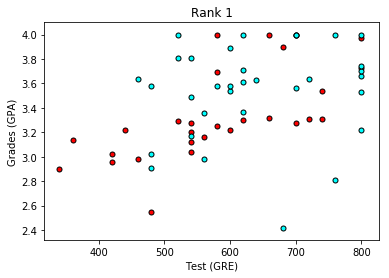

In [4]:
# Separating the ranks
data_rank1 = data[data["rank"]==1]
data_rank2 = data[data["rank"]==2]
data_rank3 = data[data["rank"]==3]
data_rank4 = data[data["rank"]==4]

# Plotting the graphs
plot_points(data_rank1)
plt.title("Rank 1")
plt.show()
#plot_points(data_rank2)
#plt.title("Rank 2")
#plt.show()

## Data Plumbing

In [5]:
# One hot encode rank
one_hot_data = pd.concat([data, pd.get_dummies(data['rank'], prefix='rank')], axis=1)
one_hot_data = one_hot_data.drop('rank', axis=1)

# Create vector of scaled data
processed_data = one_hot_data[:]
processed_data.loc[:,'gpa'] *= np.divide(1, 4.)
processed_data.loc[:,'gre'] *= np.divide(1, 800.)

processed_data[:3]

,admit,gre,gpa,rank_1,rank_2,rank_3,rank_4
0,0,0.475,0.9025,0,0,1,0
1,1,0.825,0.9175,0,0,1,0
2,1,1.000,1.0000,1,0,0,0


Split the data into a Training and a Testing set. The size of the testing set will be 10% of the total data.

In [6]:
sample = np.random.choice(processed_data.index, size=int(len(processed_data)*0.9), replace=False)
train_data, test_data = processed_data.iloc[sample], processed_data.drop(sample)

print("Number of training samples is", len(train_data))
print("Number of testing samples is", len(test_data))
print(train_data[:3])
print(test_data[:3])

Number of training samples is 360
Number of testing samples is 40
     admit    gre     gpa  rank_1  rank_2  rank_3  rank_4
132      0  0.725  0.8500       0       1       0       0
26       1  0.775  0.9025       1       0       0       0
15       0  0.600  0.8600       0       0       1       0
    admit   gre     gpa  rank_1  rank_2  rank_3  rank_4
3       1  0.80  0.7975       0       0       0       1
29      0  0.65  0.8225       1       0       0       0
35      0  0.50  0.7625       0       1       0       0


Split the data into features (X) and targets (y).

(admitX, admitY) Uses gre, gpa, and rank to predict admission

(rankX, rankY) Uses admission, gre, amd gpa to predict rank

In [7]:
admitX = train_data.drop('admit', axis=1).values
admitY = train_data['admit'].values
admitX_test = test_data.drop('admit', axis=1).values
admitY_test = test_data['admit'].values

admitX[:3]
admitY[:3]

array([[0.725 , 0.85  , 0.    , 1.    , 0.    , 0.    ],
       [0.775 , 0.9025, 1.    , 0.    , 0.    , 0.    ],
       [0.6   , 0.86  , 0.    , 0.    , 1.    , 0.    ]])

array([0, 1, 0])

In [8]:
rankX = train_data.drop(train_data.columns[[3,4,5,6]], axis=1).values
rankY = train_data.drop(train_data.columns[[0,1,2]], axis=1).values
rankX_test = test_data.drop(train_data.columns[[2,3]], axis=1).values
rankY_test = test_data.drop(train_data.columns[[0,1]], axis=1).values

rankX[:3]
rankY[:3]

array([[0.    , 0.725 , 0.85  ],
       [1.    , 0.775 , 0.9025],
       [0.    , 0.6   , 0.86  ]])

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0]], dtype=uint8)

# Construct Network with N layers and M nodes per layer

In [9]:
def initialize_weights(numnodes):
    allweights = []
    
    for i in range(len(numnodes)-1):
        iterbias = np.zeros( ( numnodes[i+1] , 1 ) )
        iterweight = np.random.normal(scale=1 / numnodes[i]**.5, size=(numnodes[i+1], numnodes[i]))
        
        allweights.append( np.concatenate((iterweight, iterbias), axis=1) )
        
    return allweights

Fdict={'identity':identity,
      'relu':relu,
      'sigmoid':sigmoid,
      'softmax':softmax,}

DFdict={'identity':identity,
      'relu':Drelu,
      'sigmoid':Dsigmoid,
      'softmax':Dsoftmax,}

In [10]:
NX, DX = rankX.shape
NY, DY = rankY.shape

arch = np.array([['identity', DX],
                 ['sigmoid', 4],
                 ['sigmoid', 2],
                 ['sigmoid', 3],
                 ['softmax', DY]])

Nnodes = np.array(arch[:,1]).astype(int)
functions = np.array([ Fdict.get(item,item) for item in arch[1:,0] ])
Dfunctions = np.array([ DFdict.get(item,item) for item in arch[1:,0] ])

In [11]:
def nodeinputs(functions, weights, entryX, entryY):
    inlayers = []
    inlayer = entryX
    
    for i in range(len(functions)):
        inlayer = np.dot(weights[i], np.append(inlayer, 1))
        inlayers.append(inlayer)
        inlayer = functions[i]( inlayer )
    return inlayers

def nodeoutputs(functions, inputs, entryX, entryY):
    outlayers = []
    outlayers.append(entryX)
    
    for i in range(len(functions)):
        outlayers.append(functions[i]( inputs[i] ))
    return outlayers

def loss(outputs, entryY):
    output = outputs[len(outputs) - 1]
    return np.array(-np.dot(entryY, np.log(output)))

def Dloss(outputs, entryY):
    output = outputs[len(outputs) - 1]
    if len(entryY)==len(output) and len(entryY)==1:
        return np.array( np.divide(entryY[0] - output[0], output[0]*(1 - output[0])) )
        
    elif len(entryY)==len(output) and len(entryY)>1:
        return np.array( -np.divide(entryY, output) )
    
    else:
        print('something wrong')
        return 0

In [13]:
def lossgradient(Dfunctions, weights, inputs, outputs, entryY):
    gradients = []
    initgrad = Dloss(outputs, entryY)
    
    if len(initgrad > 1):
        derivative = np.sum( initgrad*Dsoftmax( inputs[len(inputs) - 1] ), axis=0)
    elif len(initgrad == 1):
        derivative = np.sum( initgrad*Dsigmoid( inputs[len(inputs) - 1] ), axis=0)
    else:
        print('non-standard output length')
    
    for igrad in reversed(range(len(Dfunctions) - 1)):
        gradients.append(np.outer( derivative, np.append(outputs[igrad+1],0) ))
        derivative = derivative.reshape(len(derivative),1)
        derivative = derivative*weights[igrad + 1]*np.append( Dfunctions[igrad](inputs[igrad]), 0)
        derivative = np.sum(derivative, axis=0)
        derivative = derivative[:len(derivative)-1]
    derivative = derivative.reshape(len(derivative),1)    
    derivative = derivative*weights[0]
    derivative = np.sum(derivative, axis=0)
    gradients.append(np.outer( derivative, np.append(outputs[0],0) ))
    
    return list(reversed(gradients))

learnrate = 0.01
allweights = initialize_weights(Nnodes)

test_weights = initialize_weights(Nnodes)
test_nodeinputs = nodeinputs(functions, allweights, rankX[0], rankY[0]);
test_nodeoutputs = nodeoutputs(functions, test_nodeinputs, rankX[0], rankY[0]);

#loss(test_nodeoutputs, rankY[0])
#Dloss(test_nodeoutputs, rankY[0])
#lossgradient(Dfunctions, test_weights, test_nodeinputs, test_nodeoutputs, rankY[0])

## The program below runs away because it figures out it can keep reducing loss by increasing weights

In [14]:
learnrate = 0.01
allweights = initialize_weights(Nnodes)

for i in range(50):
    allinputs = nodeinputs(functions, allweights, rankX[0], rankY[0])
    alloutputs = nodeoutputs(functions, allinputs, rankX[0], rankY[0])
    
    listoutputs = nodeoutputs(functions, allinputs, rankX[0], rankY[0])
    
    gradstep = lossgradient(Dfunctions, allweights, allinputs, alloutputs, rankY[0])

    allweights = [np.add(allweights[iwgt], learnrate*gradstep[iwgt]) for iwgt in range(len(allweights))]

    if i%10==0:
        print(loss(alloutputs, rankY[0]))

1.9908366621141054
1.8436005904445294
1.7038616543995428
1.5722723526608147
1.449258271538126


In [21]:
# Neural Network hadmitYperparameters
epochs = 1000
learnrate = 0.5

# Training function
def train_nn(features, targets, epochs, learnrate):
    
    # Use to same seed to make debugging easier
    np.random.seed(42)

    n_records, n_features = features.shape
    last_loss = None

    # Initialize weights
    weights = np.random.normal(scale=1 / n_features**.5, size=n_features)

    for e in range(epochs):
        del_w = np.zeros(weights.shape)
        for dataX, dataY in zip(features, targets):
            # Loop through all records, admitX is the input, admitY is the target

            # Activation of the output unit
            #   Notice we multipladmitY the inputs and the weights here 
            #   rather than storing h as a separate variable 
            output = sigmoid(np.dot(dataX, weights))

            # The error, the target minus the network output
            error = error_formula(dataY, output)

            # The error term
            error_term = error_term_formula(dataX, dataY, output)

            # The gradient descent step, the error times the gradient times the inputs
            del_w += error_term * dataX

        # Update the weights here. The learning rate times the 
        # change in weights, divided by the number of records to average
        weights += learnrate * del_w / n_records

        # Printing out the mean square error on the training set
        if e % (epochs / 10) == 0:
            out = sigmoid(np.dot(features, weights))
            loss = np.mean((out - targets) ** 2)
            print("Epoch:", e)
            if last_loss and last_loss < loss:
                print("Train loss: ", loss, "  WARNING - Loss Increasing")
            else:
                print("Train loss: ", loss)
            last_loss = loss
            print("=========")
    print("Finished training!")
    return weights
    
weights = train_nn(admitX, admitY, epochs, learnrate)

Epoch: 0
Train loss:  0.2775934651243164
Epoch: 100
Train loss:  0.2144095431367119
Epoch: 200
Train loss:  0.2154547009201849   WARNING - Loss Increasing
Epoch: 300
Train loss:  0.21577870630097568   WARNING - Loss Increasing
Epoch: 400
Train loss:  0.21571925703978923
Epoch: 500
Train loss:  0.21558234589601522
Epoch: 600
Train loss:  0.21543682330828717
Epoch: 700
Train loss:  0.21529719523391916
Epoch: 800
Train loss:  0.21516695096571253
Epoch: 900
Train loss:  0.21504741880729447
Finished training!


## Calculating the Accuracy on the Test Data

In [22]:
# Calculate accuracy on test data
test_out = sigmoid(np.dot(admitX_test, weights))
predictions = test_out > 0.5
accuracy = np.mean(predictions == admitY_test)
print("Prediction accuracy: {:.3f}".format(accuracy))

Prediction accuracy: 0.625
